In [1]:
# import gymnasium as gym
import gym
from gym import spaces
import numpy as np
import pygame
import pickle
import matplotlib.pyplot as plt
import random

In [2]:
class MazeGameEnv(gym.Env):
    """
        Maze Game Environment

        The maze is represented as a 2D numpy array where:
            'S' is the start position
            'G' is the goal position
            'X' is a wall
            ' ' is an empty space

        The agent can move in 4 directions:
            0: Up
            1: Down
            2: Left
            3: Right

        The agent receives a reward of 1.0 when it reaches the goal position and 0.0 otherwise.

        :param maze: 2D numpy array representing the maze
        :type maze: np.ndarray

        :param cell_size: Size of each cell in the maze
        :type cell_size: int

        :param screen: Pygame screen object
        :type screen: pygame.Surface

        :param start_pos: Start position of the agent
        :type start_pos: Tuple[int, int]

        :param goal_pos: Goal position of the agent
        :type goal_pos: Tuple[int, int]

        :param current_pos: Current position of the agent
        :type current_pos: Tuple[int, int]

        :param num_rows: Number of rows in the maze
        :type num_rows: int

        :param num_cols: Number of columns in the maze
        :type num_cols: int

        :param action_space: Action space of the environment
        :type action_space: gym.spaces.Discrete

        :param observation_space: Observation space of the environment
        :type observation_space: gym.spaces.Tuple

        :param screen: Pygame screen object
        :type screen: pygame.Surface

        :param cell_size: Size of each cell in the maze
        :type cell_size: int
    """

    def __init__(self, maze):
        super().__init__()
        self.maze = np.array(maze) # 2d array
        self.start_pos = (np.where(self.maze == 'S')[0][0], np.where(self.maze == 'S')[1][0])
        self.goal_pos = (np.where(self.maze == 'G')[0][0], np.where(self.maze == 'G')[1][0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape
        self.X_pos = self.locate_X()
        self.move_count = 0

        self.action_space = spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(self.num_rows * self.num_cols)

        # print(self.X_pos)

        pygame.init()
        self.cell_size = 125
        self.screen = pygame.display.set_mode((self.num_cols * self.cell_size, self.num_rows * self.cell_size))

    def reset(self, seed=None, options=None):
        """
            Reset agent position to start position
        """
        super().reset(seed=seed)
        self._init_temp_walls()
        self.current_pos = self.start_pos
        state_index = self._pos_to_index(self.current_pos)
        self.move_count = 0
        return state_index, {}

    def locate_X(self):
        temp_X_pos = []
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.maze[row, col].startswith('X'):
                    temp_X_pos.append((row, col, self.maze[row, col]))
        return temp_X_pos

    def step(self, action):
        """
            Updates agent’s position according to the action taken and provide reward
        """
        self._update_Xes()        
        moved = False

        new_pos = np.array(self.current_pos)
        direction = self._translate_action(action)
        new_pos = new_pos[0] + direction[0], new_pos[1] + direction[1]

        if self._is_valid_position(new_pos):
            self.current_pos = new_pos
            moved = True

        if np.array_equal(np.array(self.current_pos), np.array(self.goal_pos)):
            reward = 1.0
            done = True
        # elif self.move_count > self.num_rows * self.num_cols * 5:
        #     reward = 
        #     done = True
        else:
            reward = -0.1/(self.num_rows * self.num_cols)
            done = False

        state_index = self._pos_to_index(self.current_pos)
        self.move_count += 1
        return state_index, reward, done, moved, {},

    def _init_temp_walls(self):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.maze[row, col].endswith('$'):
                    rand = random.randint(0, 1)
                    if rand == 0:
                        self.maze[row, col] = '.$'
                    else:
                        self.maze[row, col] = '#$'

    def _is_valid_position(self, pos):
        row, col = pos

        if row < 0 or col < 0 or row >= self.num_rows or col >= self.num_cols:
            return False
        
        if self.maze[row, col].startswith('#'):
            return False

        if self.maze[row, col].startswith('X'):
            return False
        
        return True
    
    def _translate_action(self, action):
        if action == 0:
            return (-1, 0) # Up
        if action == 1:
            return (1, 0) # Down
        if action == 2:
            return (0, -1) # Left
        if action == 3:
            return (0, 1) # Right
        else:
            return (0, 0)

    def _is_valid_X_position(self, pos):
        row, col, _ = pos

        if row < 0 or col < 0 or row >= self.num_rows or col >= self.num_cols:
            return False
        
        if row == self.current_pos[0] and col == self.current_pos[1]:
            return False

        if self.maze[row, col].startswith('#') or self.maze[row, col].startswith('X') or self.maze[row, col] == 'S' or self.maze[row, col] == 'G':
            return False

        return True

    def _update_Xes(self):
        for X_pos in self.X_pos:
            valid = False
            new_X_pos = X_pos
            counter = 0
            while valid == False:
                rand_move = 1
                if X_pos[2].endswith('^'):
                    rand_dir = random.randint(0, 1)
                elif X_pos[2].endswith('>'):
                    rand_dir = random.randint(2, 3)
                else :
                    rand_dir = random.randint(0, 3)

                direction = self._translate_action(rand_dir)

                new_X_pos = X_pos[0] + direction[0] * rand_move, X_pos[1] + direction[1] * rand_move, X_pos[2]
                if self._is_valid_X_position(new_X_pos):
                    valid = True
                    self.maze[X_pos[0], X_pos[1]] = '.'
                    self.maze[new_X_pos[0], new_X_pos[1]] = X_pos[2]

                    self.X_pos.remove(X_pos)
                    self.X_pos.append(new_X_pos)
                else:
                    counter += 1
                    if counter > 5:
                        break
            
            

    def _pos_to_index(self, pos):
        return pos[0] * self.num_cols + pos[1]
    
    def render(self):
        """
            Render game environment using pygame by drawing elements for each cell by using nested loops. 
            You can simply print the maze grid as well, no necessary requirement for pygame
        """
        self.screen.fill((255, 255, 255))

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                # try:
                #     print(np.array(self.current_pos)==np.array([row,col]).reshape(-1,1))
                # except Exception as e:
                #     print('Initial state')

                if self.maze[row, col].startswith('#'):
                    pygame.draw.rect(self.screen, (0, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.rect(self.screen, (0, 255, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'G':
                    pygame.draw.rect(self.screen, (255, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col].startswith('X'):
                    pygame.draw.rect(self.screen, (125, 125, 125), (cell_left, cell_top, self.cell_size, self.cell_size))

                if np.array_equal(np.array(self.current_pos), np.array([row, col])):  # Agent position
                    pygame.draw.rect(self.screen, (0, 0, 255), (cell_left, cell_top, self.cell_size, self.cell_size))

        pygame.display.update()

In [3]:
gym.register(
    id='MazeGame-v0',
    entry_point=MazeGameEnv,
    kwargs={'maze': None}
)

In [4]:
from copy import deepcopy
def run(episodes, is_training=True, render=False):
    """
    Run the maze problem

    :param episodes: number of episodes to run
    :param is_training: if True, the agent will learn, otherwise it will use a pre-trained model
    :return: None
    """

    maze = [
        ['S', '$', '.',  'X>', '.',  '.',  '.',  '.'],
        ['.', '#', '.',  '#',  'X^',  '#',  '.',  '.'],
        ['.', '#', '.',  '#',  '.',  '#',  '#',  '$'],
        ['.', '.', '.',  'X>',  '.',  '.',  '.',  '.'],
        ['.', '.', '.',  '$',  '.',  '$',  'X^', '#'],
        ['.', '$', 'X^', '$',  '.',  '$',  '.',  '.'],
        ['.', '.', '.',  '.',  'X>',  '.', '.',  'G'],
        ['$', '$', '$',  '$',  '$',  '$',  '$',  '#']
    ]

    env = gym.make('MazeGame-v0', maze=maze)

    if(is_training):
        q = np.zeros((len(maze) * len(maze[0]), 4))
    else:
        f = open('maze_game.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9
    discount_factor_g = 0.9

    epsilon = 1
    epsilon_decay_rate = 0.0001
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False
        rewards = 0
        not_moved_counter = 0
        while (not terminated):

            if render:
                pygame.event.get()

            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state, :])
           
            if is_training:
                new_state, reward, terminated, moved, _ = env.step(action)
            else:
                moved = False
                temp = deepcopy(q)
                while not moved:
                    action = np.argmax(temp[state, :])
                    new_state, reward, terminated, moved, _ = env.step(action)
                    temp[state, action] = -np.inf
                
            if render:
                env.render()
                pygame.time.wait(200)

            if is_training:
                q[state, action] = q[state, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state, :]) - q[state, action]
                )

            state = new_state
            rewards += reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if epsilon == 0:
            learning_rate_a = 0.0001

        rewards_per_episode[i] = rewards
        if i % 100 == 0:
            print(f'Episode {i+1}/{episodes}, rewards: {rewards}')

    env.close()

    if is_training:
        f = open('maze_game.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(mean_rewards)
    plt.savefig(f'maze_game_mean.png')

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.savefig(f'maze_game_sum.png')

/Users/piotrgasiorek/miniconda3/envs/IOWADC/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/15000, rewards: -0.10781250000000386
Episode 101/15000, rewards: -1.2968749999999365
Episode 201/15000, rewards: 0.3812499999999954
Episode 301/15000, rewards: 0.5515624999999978
Episode 401/15000, rewards: 0.925
Episode 501/15000, rewards: 0.7906250000000005
Episode 601/15000, rewards: 0.909375
Episode 701/15000, rewards: 0.7984375000000005
Episode 801/15000, rewards: 0.4781249999999968
Episode 901/15000, rewards: 0.8390625000000003
Episode 1001/15000, rewards: 0.925
Episode 1101/15000, rewards: 0.8890625000000001
Episode 1201/15000, rewards: 0.9062500000000001
Episode 1301/15000, rewards: 0.8109375000000004
Episode 1401/15000, rewards: 0.8968750000000001
Episode 1501/15000, rewards: 0.5249999999999975
Episode 1601/15000, rewards: 0.909375
Episode 1701/15000, rewards: 0.6734374999999996
Episode 1801/15000, rewards: 0.8093750000000004
Episode 1901/15000, rewards: 0.8171875000000004
Episode 2001/15000, rewards: 0.5515624999999978
Episode 2101/15000, rewards: 0.915625
Episode 2

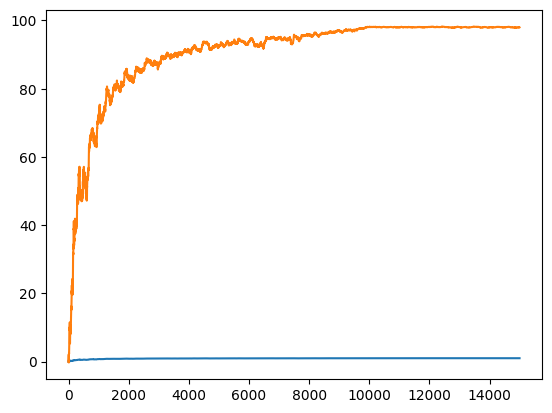

In [5]:
run(15000, is_training=True, render=False)

In [6]:
run(10, is_training=False, render=True) # Test the model

/Users/piotrgasiorek/miniconda3/envs/IOWADC/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/10, rewards: 0.9562499999999999


KeyboardInterrupt: 